In [16]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from krxns.net_construction import construct_reaction_network, extract_compounds
from krxns.config import filepaths
from krxns.utils import str2int
from krxns.networks import SuperMultiDiGraph
from krxns.cheminfo import draw_reaction
from IPython.display import SVG
import json
from scipy.stats import spearmanr
from itertools import chain
from collections import defaultdict
import ipywidgets as widgets
from ipywidgets import interact

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
whitelist_fn = "top_50_whitelist.json"

# Load known reaction data
with open(filepaths['data'] / 'sprhea_240310_v3_mapped.json', 'r') as f:
    krs = json.load(f)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    op_cxns = str2int(json.load(f))

# Load sim connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_similarity.json', 'r') as f:
    sim_cxn = str2int(json.load(f))

with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_side_counts.json', 'r') as f:
    side_counts = str2int(json.load(f))

# Load coreactant whitelist
with open(filepaths['coreactants'] / whitelist_fn, 'r') as f:
    coreactant_whitelist = json.load(f)

kcs, smi2id = extract_compounds(krs) # Get known compounds

tani_sim_mat = np.load(filepaths['sim_mats'] / "tanimoto.npy") # Tanimoto structural sim mat

In [18]:
G = SuperMultiDiGraph()
edges, nodes = construct_reaction_network(
    operator_connections=op_cxns,
    similarity_connections=sim_cxn,
    side_counts=side_counts,
    reactions=krs,
    connect_nontrivial=False,
    coreactant_whitelist=coreactant_whitelist,
    atom_lb=0.2,
    add_multi_mol_nodes=True
)
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [19]:
paths = nx.shortest_path(G)

# Filter out self-paths
tmp = {}
for i in paths:
    destinations = {j: elt for j, elt in paths[i].items() if i != j}
    if destinations:
        tmp[i] = destinations
paths = tmp

<class 'networkx.utils.decorators.argmap'> compilation 4:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


In [20]:
path_lens = {}
for i in paths:
    for j in paths[i]:
        path_lens[(i, j)] = len(paths[i][j])

In [21]:
G.nodes[0]

{'smiles': 'CC(=O)NC1C(OP(=O)(O)OP(=O)(O)OCC2OC(n3ccc(=O)[nH]c3=O)C(O)C2O)OC(CO)C(O)C1OC(C)C(=O)NC(C)C(=O)NC(CCC(=O)NC(CCCC(N)C(=O)O)C(=O)NC(C)C(=O)NC(C)C(=O)O)C(=O)O.CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP(=O)(O)O',
 'names': ('UDP-N-acetyl-alpha-D-muramoyl-L-alanyl-gamma-D-glutamyl-meso-2,6-diaminopimeloyl-D-alanyl-D-alanine',
  'di-trans,octa-cis-undecaprenyl phosphate'),
 'cpd_ids': (2237, 2614)}

In [9]:
path_tanis = defaultdict(dict)
path_tanis_all_successors = defaultdict(dict)
n_paths = 0
ds = 100
for i in list(paths.keys())[::ds]:
    for j in paths[i]:
        col_idxs = paths[i][j]
        path_tanis[i][j] = tani_sim_mat[j, col_idxs]

        if len(col_idxs) > 2:
            succ_scores = [tani_sim_mat[j, list(G.successors(c))] for c in col_idxs[:-2]]
            path_tanis_all_successors[i][j] = succ_scores
        
        n_paths += 1
print(f"# paths = {n_paths}")

IndexError: index 9686 is out of bounds for axis 0 with size 8777

In [45]:
path_spearmans = {}
for i in list(path_tanis.keys()):
    path_spearmans[i] = {}
    for j in path_tanis[i]:
        tanis = path_tanis[i][j]
        path_spearmans[i][j] = spearmanr(np.arange(len(tanis)), tanis).statistic

/tmp/ipykernel_303958/558657920.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  path_spearmans[i][j] = spearmanr(np.arange(len(tanis)), tanis).statistic


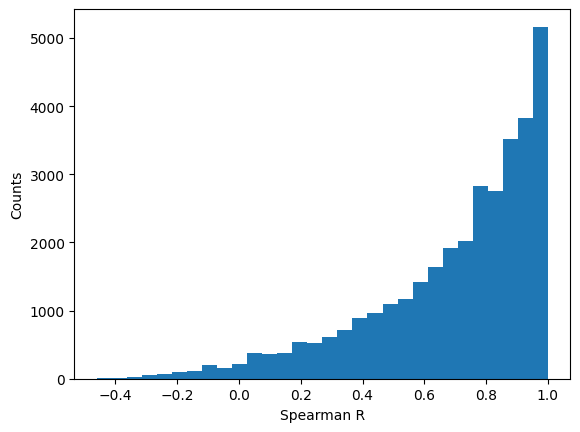

In [46]:
spearman_rs = list(chain(*[elt.values() for elt in path_spearmans.values()]))
fig, ax = plt.subplots()
ax.hist(spearman_rs, bins=30)
ax.set_ylabel("Counts")
ax.set_xlabel("Spearman R")
plt.show()

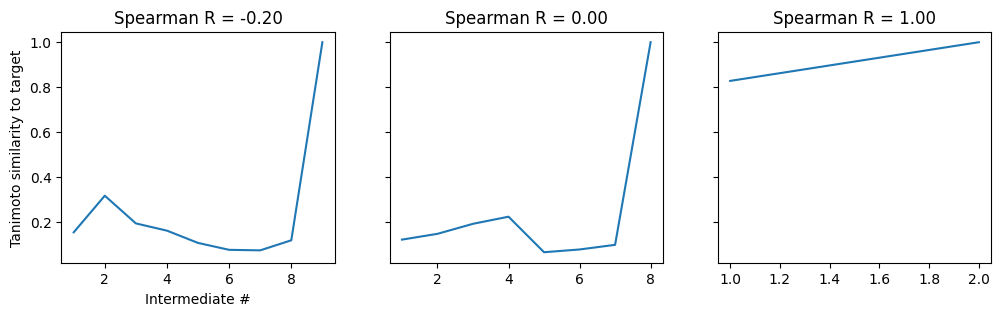

In [47]:
negative_spearman_traces = {}
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j] + 0.2) < 1e-4:
            negative_spearman_traces[(i, j)] = path_tanis[i][j]

zero_spearman_traces = {}
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j]) < 1e-4:
            zero_spearman_traces[(i, j)] = path_tanis[i][j]

one_spearman_traces = {}
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j] - 1) < 1e-4:
            one_spearman_traces[(i, j)] = path_tanis[i][j]

fig, ax = plt.subplots(ncols=3, figsize=(12, 3), sharey=True)

traces = [negative_spearman_traces, zero_spearman_traces, one_spearman_traces]

idx = 2
sts = [list(elt.keys())[min(idx, len(elt) - 1)] for elt in traces]

plot_it = lambda i, st : ax[i].plot(np.arange(1, len(traces[i][st]) + 1), traces[i][st])

for i, st in enumerate(sts):
    plot_it(i, st)
    s, t = st
    ax[i].set_title(f"Spearman R = {path_spearmans[s][t]:.2f}")

ax[0].set_ylabel(f"Tanimoto similarity to target")
ax[0].set_xlabel("Intermediate #")
plt.show()

In [48]:
def show_path(pair, topk = 1):
    source, target = pair
    overall = ">>".join((G.nodes[source]['smiles'], G.nodes[target]['smiles']))
    print("Overall: ".upper(), f"{G.nodes[source]['name']} >> {G.nodes[target]['name']}")
    print(f"Spearman: {path_spearmans[source][target]:.2f}")
    display(SVG(draw_reaction(overall)))
    node_path, edge_path = G.shortest_path(source, target, rm_req_target=False)
    for i, step in enumerate(edge_path):
        print(f"STEP #{i+1}")
        for edge in step[:topk]:
            print([(k, v) for k, v in edge.items() if k != 'smarts'])
            display(SVG(draw_reaction(edge['smarts'])))

In [49]:
options = [(i, pair) for i, pair in enumerate(sts)]
dd = widgets.Dropdown(options=options, value=options[0][1])

_ = interact(show_path, pair=dd)

interactive(children=(Dropdown(description='pair', options=((0, (3114, 3350)), (1, (499, 2065)), (2, (139, 122…

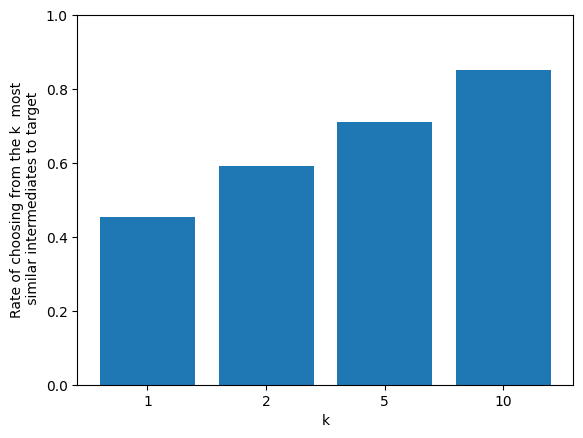

In [51]:
topks = [1, 2, 5, 10]
positive = [0 for _ in range(len(topks))]
n_steps = [0 for _ in range(len(topks))]
for x, k in enumerate(topks):
    for i in path_tanis_all_successors:
        for j in path_tanis_all_successors[i]:
            for step in range(1, len(path_tanis[i][j]) - 1):
                successors = path_tanis_all_successors[i][j][step - 1]
                if len(successors) > k:

                    chosen = path_tanis[i][j][step]
                    n_steps[x] += 1
                    srt_successors = sorted(successors, reverse=True)

                    if srt_successors.index(chosen) < k:
                        positive[x] += 1

fig, ax = plt.subplots()
ax.bar(list(range(len(topks))), [positive[i] / n_steps[i] for i in range(len(topks))], tick_label=topks)
ax.set_ylim(0, 1)
ax.set_xlabel("k")
ax.set_ylabel("Rate of choosing from the k  most\n similar intermediates to target")
plt.show()


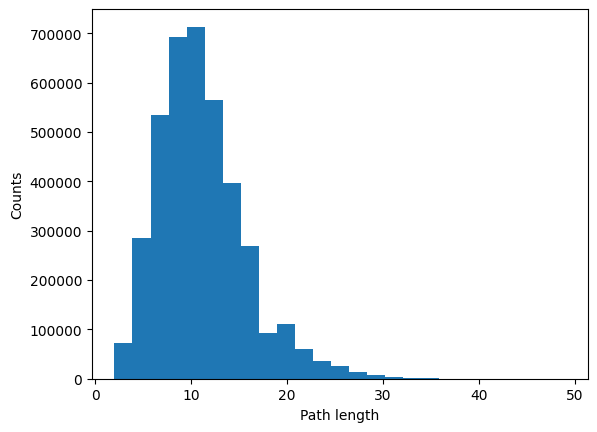

In [52]:
spearman_rs = list(path_lens.values())
fig, ax = plt.subplots()
ax.hist(spearman_rs, bins=25)
ax.set_ylabel("Counts")
ax.set_xlabel("Path length")
plt.show()

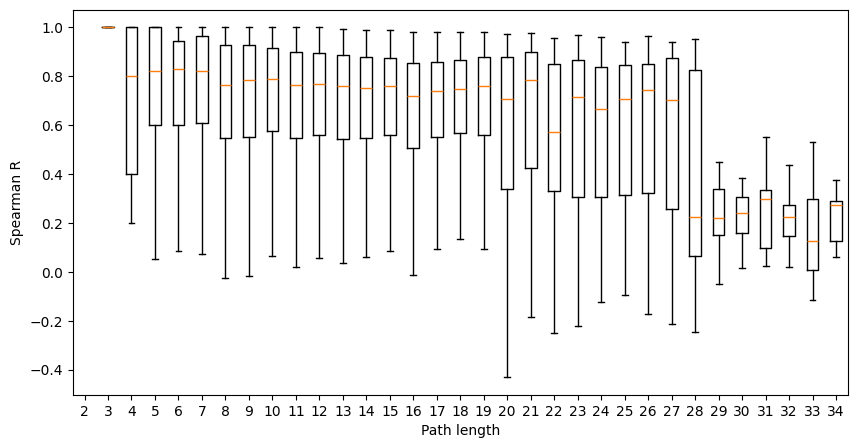

In [62]:
spearman_by_len = defaultdict(list)
for i in list(paths.keys())[::ds]:
    for j in paths[i]:
        plen = path_lens[(i, j)]
        r = path_spearmans[i][j]
        spearman_by_len[plen].append(r)

x = sorted(spearman_by_len.keys())
stats = []
box_data = []
for elt in x:
    scatter = np.array(spearman_by_len[elt])
    stats.append((scatter.mean(), scatter.std()))
    box_data.append(scatter)


mu, sig = zip(*stats)

fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot(box_data, positions=x, showfliers=False)
ax.set_ylabel("Spearman R")
ax.set_xlabel("Path length")
plt.show()


In [98]:
# NOTE: this will have to change after change coreactant whitelist

import krxns
from collections import Counter
from itertools import product
def count_coreactant_debts(edge_path: list, coreactant_whitelist: dict):
    paths = product(*edge_path) # Get all possible paths given multipath
    for path in paths:
        coreactant_counter = Counter()
        for step in path:
            for rct, stoich in step['requires'].items():
                if rct in coreactant_whitelist:
                    coreactant_counter[rct] -= stoich
                else:
                    print(f"{rct} found not in whitelist...")
            for pdt, stoich in step['other_products'].items():
                if pdt in coreactant_whitelist:
                    coreactant_counter[pdt] += stoich
                

        # print(coreactant_counter)
        # debts = {}
        # counted_other = set()
        # for smi in sorted(coreactant_counter.keys()):
        #     if smi in counted_other:
        #         continue
        #     else:



_, edge_path = G.shortest_path(0, 8735)
count_coreactant_debts(edge_path, coreactant_whitelist)




Counter({'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1, 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': -1})
Counter({'*C(=O)C(=O)O': 1, 'N': 1, '*C(N)C(=O)O': -1, 'O': -1})
Counter({'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1, 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': -1})
Counter({'*NC(CS)C(*)=O': 2, 'O=S(O)O': 1, '*NC(CSSCC(N*)C(*)=O)C(*)=O': -1, 'S': -1, 'O': -3})
Counter({'*C(=O)C(=O)O': 1, '*C(O)C(=O)O': -1})


In [92]:
list()

In [96]:
list(path_lens)[:10]

[(0, 8735),
 (2, 1936),
 (2, 1469),
 (2, 5899),
 (2, 6799),
 (2, 6035),
 (2, 8297),
 (2, 6493),
 (2, 6496),
 (2, 1154)]

In [90]:
list(product([1,2], [3,4], [5,6]))

[(1, 3, 5),
 (1, 3, 6),
 (1, 4, 5),
 (1, 4, 6),
 (2, 3, 5),
 (2, 3, 6),
 (2, 4, 5),
 (2, 4, 6)]

In [94]:
ctr = Counter()
ctr[0]

0

In [15]:
from krxns.cheminfo import MorganFingerPrinter, tanimoto_similarity
from rdkit import Chem
from time import perf_counter

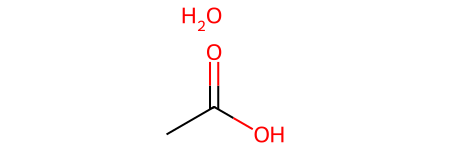

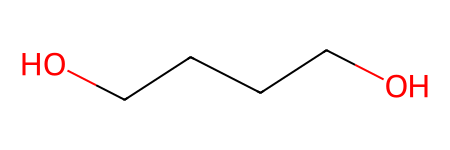

(None, None)

In [13]:

smi1 = "CC(=O)O.O"
smi2 = "OCCCCO"
mol1 = Chem.MolFromSmiles(smi1)
mol2 = Chem.MolFromSmiles(smi2)
display(mol1), display(mol2)

In [20]:
mfper = MorganFingerPrinter()
ns = [1, 10, 100, 1_000, 10_000]
for n in ns:
    tic = perf_counter()
    for i in range(n):
        mfper.fingerprint(mol1)
    toc = perf_counter()
    print(n, toc - tic)

1 0.0006534540007123724
10 0.005830635011079721
100 0.051572643002145924
1000 0.516698310006177
10000 5.479741641000146


In [31]:
import numpy as np
import timeit

# Create large binary arrays
array1 = np.random.randint(0, 2, size=10**6)
array2 = np.random.randint(0, 2, size=10**6)

# Timing np.logical_or
time_logical_or = timeit.timeit(lambda: np.logical_or(array1, array2).astype(np.int16), number=100)
print(f"np.logical_or time: {time_logical_or:.6f} seconds")

# Timing | operator
time_operator = timeit.timeit(lambda: array1 | array2, number=100)
print(f"| operator time: {time_operator:.6f} seconds")


np.logical_or time: 0.084094 seconds
| operator time: 0.114668 seconds


In [23]:
np.logical_or(array1, array2).astype(np.int16)

array([1, 1, 1, ..., 1, 1, 1], dtype=int16)